# Downside Measures: SemiDeviation, VaR and CVaR

We're going to look at a few measures of downside risk. We've already seen how to compute drawdowns, but we're going to look at 3 popular measures, and we are going to develop code to compute these and add them to our toolbox.

The first measure is the simplest, which is the semideviation, which is nothing more than the volatility of the subset of returns that are negative.

The code is very simple:

```python
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)
```


In [1]:
import pandas as pd
import edhec_risk_kit_106 as erk
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
hfi = erk.get_hfi_returns()

/Users/johnmoses/Workstore/coursera-investment-management-specialization/C1-introduction-to-portfolio-construction-and-analysis-with-python/edhec_risk_kit_106.py:36: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  hfi = pd.read_csv("data/edhec-hedgefundindices.csv",


In [3]:
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)


In [4]:
erk.semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [5]:
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [6]:
erk.semideviation(hfi).sort_values()

Global Macro              0.006579
Merger Arbitrage          0.008875
Equity Market Neutral     0.009566
Funds Of Funds            0.012122
Relative Value            0.012244
CTA Global                0.012443
Long/Short Equity         0.014051
Distressed Securities     0.015185
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Convertible Arbitrage     0.019540
Short Selling             0.027283
Emerging Markets          0.028039
dtype: float64

In [7]:
ffme = erk.get_ffme_returns()
erk.semideviation(ffme)

SmallCap    0.051772
LargeCap    0.040245
dtype: float64

In [8]:
# This will not work: erk.semideviation([1,2,3,4])

# VaR and CVaR

We'll look at three different ways to compute Value At Risk

1. Historic VaR
2. Parametric Gaussian VaR
3. Modified (Cornish-Fisher) VaR

To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

Fortunately, numpy has a `np.percentile` function that computes exactly that.

Add the following code to the `edhec_risk_kit.py` file:

```python

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")        
```


In [14]:
import numpy as np
np.percentile(hfi, a=)

SyntaxError: invalid syntax (2402568339.py, line 2)

In [12]:
erk.var_historic(hfi, level=1)

Convertible Arbitrage     0.031776
CTA Global                0.049542
Distressed Securities     0.046654
Emerging Markets          0.088466
Equity Market Neutral     0.018000
Event Driven              0.048612
Fixed Income Arbitrage    0.041672
Global Macro              0.024316
Long/Short Equity         0.049558
Merger Arbitrage          0.025336
Relative Value            0.026660
Short Selling             0.113576
Funds Of Funds            0.039664
dtype: float64

Note that for reporting purposes, it is common to invert the sign so we report a positive number to represent the _loss_ i.e. the amount that is at risk.

# Conditional VaR aka Beyond VaR

Now that we have the VaR, the CVaR is very easy. All we need is to find the mean of the numbers that fell below the VaR!

In [15]:
erk.cvar_historic(hfi, level=1).sort_values()

Global Macro              0.029333
Equity Market Neutral     0.036100
Merger Arbitrage          0.036233
Relative Value            0.052367
CTA Global                0.054767
Funds Of Funds            0.061133
Long/Short Equity         0.061867
Distressed Securities     0.070967
Event Driven              0.071267
Fixed Income Arbitrage    0.072467
Convertible Arbitrage     0.086100
Short Selling             0.123867
Emerging Markets          0.141167
dtype: float64

In [16]:
erk.cvar_historic(ffme)

SmallCap    0.162609
LargeCap    0.121277
dtype: float64

## Parametric Gaussian VaR

The idea behind this is very simple. If a set of returns is normally distributed, we know, for instance, that 50% of the returns are below the mean and 50% are above.

We also know that approx two thirds of the returns lie within 1 standard deviation. That means one third lie beyond one standard deviation from the mean. Since the normal distribution is symmetric, approximately one sixth (approx 16%) lie below one standard deviation away from the mean. Therefore, if we know the mean and standard deviation and if we assume that the returns are normally distributed, the 16% VaR would be the mean minus one standard deviation.

In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.

`scipy.stat.norm` contains a function `ppf()` which does exactly that. It takes a percentile such as 0.05 or 0.01 and gives you the z-score corresponding to that in the normal distribution.

In [17]:
from scipy.stats import norm
norm.ppf(.5)

0.0

In [18]:
norm.ppf(.16)

-0.994457883209753

Therefore, all we need to do to estimate the VaR using this method is to find the z-score corresponding to percentile level, and then add that many standard deviations to the mean, to obtain the VaR.

```python
from scipy.stats import norm
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))
```

In [19]:
erk.var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [20]:
erk.var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

# Cornish-Fisher Modification

The Cornish-Fisher modification is an elegant and simple adjustment.

The z-score tells us how many standard deviations away from the mean we need to go to find the VaR. If the returns arent normal, we know that z-score will give us an inaccurate number. The basic idea is that since we can observe the skewness and kurtosis of the data, we can adjust the z-score up or down to come up with a modifed z-score. e.g. intuitively, all other things being equal, if the skewness is negative, we'll decrease the z-score further down, and if the skewness is positive, we'll push it up.

The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$


We can modify the previous function by adding a "modified" parameter with a default value of `True` as follows. If `True` then the following piece of code is executed, which modifes `z`:

```python
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
```

The rewritten function is:

```python
from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        
    return -(r.mean() + z*r.std(ddof=0))

```

We can now compare the different methods:

<AxesSubplot:title={'center':'Hedge Fund Indices: VaR at 5%'}>

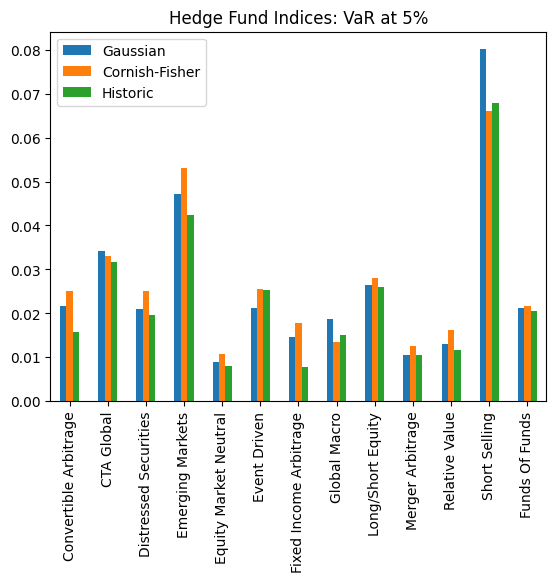

In [21]:
var_table = [erk.var_gaussian(hfi), 
             erk.var_gaussian(hfi, modified=True), 
             erk.var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")

Note that in some cases, the cornish-fisher VaR is lower i.e. estimates a smaller loss than you would get from a pure gaussian assumption. That can happen if the observed skewness is positive, as is the case for "Short Selling" and "Global Macro"

In [22]:
erk.skewness(hfi).sort_values(ascending=False)

Global Macro              0.982922
Short Selling             0.767975
CTA Global                0.173699
Funds Of Funds           -0.361783
Long/Short Equity        -0.390227
Emerging Markets         -1.167067
Distressed Securities    -1.300842
Merger Arbitrage         -1.320083
Event Driven             -1.409154
Relative Value           -1.815470
Equity Market Neutral    -2.124435
Convertible Arbitrage    -2.639592
Fixed Income Arbitrage   -3.940320
dtype: float64